<a href="https://colab.research.google.com/github/ria-heikkila/fish_species_recognizer/blob/master/fish_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import keras
from keras import regularizers, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Conv2D, MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from PIL import ImageFile
import numpy as np

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
image_height = 150
image_width = 220
classes = ["aji", "ika", "iwashi", "katsuo", "maguro", "saba", "salmon", "sanma", "tai", "tako"]
num_classes = len(classes)

In [6]:
#データの準備
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./drive/My Drive/data_fish/train"
validate_dir = "./drive/My Drive/data_fish/validate"
batch_size = 16

#Training Set
train_set = train_datagen.flow_from_directory(train_dir,
                                             target_size=(image_height,image_width),
                                             batch_size=batch_size,
                                             class_mode='categorical')
#Validation Set
test_set = test_datagen.flow_from_directory(validate_dir,
                                           target_size=(image_height,image_width),
                                           batch_size =batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 1000 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


In [7]:
base_model = InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [9]:
import os

# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

# ModelCheckpoint
weights_dir='./weights/'
if os.path.exists(weights_dir)==False:os.mkdir(weights_dir)
model_checkpoint = ModelCheckpoint(
    weights_dir + "val_accuracy{val_accuracy:.3f}.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    period=3
)

# reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

In [10]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

# 250層以降を学習させる
for layer in model.layers[:249]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True

for layer in model.layers[249:]:
    layer.trainable = True

# layer.trainableの設定後に、必ずcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [11]:
%%time
hist = model.fit_generator(
    train_set,
    steps_per_epoch=1000 // batch_size,
    epochs=20,
    callbacks = [early_stopping, reduce_lr],
    validation_data=test_set,
    validation_steps=410 // batch_size
)
model.save('fish_modelv3_keras.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
62/62 [==============================] - 392s 6s/step - loss: 1.6010 - acc: 0.5181 - val_loss: 1.2431 - val_acc: 0.7325
Epoch 2/20
62/62 [==============================] - 371s 6s/step - loss: 0.8687 - acc: 0.7137 - val_loss: 0.9627 - val_acc: 0.7234
Epoch 3/20
62/62 [==============================] - 364s 6s/step - loss: 0.5254 - acc: 0.8206 - val_loss: 0.8734 - val_acc: 0.7843
Epoch 4/20
62/62 [==============================] - 364s 6s/step - loss: 0.4701 - acc: 0.8488 - val_loss: 1.0222 - val_acc: 0.7487
Epoch 5/20
62/62 [==============================] - 367s 6s/step - loss: 0.3397 - acc: 0.8851 - val_loss: 0.9828 - val_acc: 0.7868
Epoch 6/20
62/62 [==============================] - 367s 6s/step - loss: 0.3639 - acc: 0.8921 - val_loss: 0.9107 - val_acc: 0.7792

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
62/62 [====================

In [13]:
test_loss, test_acc = model.evaluate_generator(test_set, steps=410)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.5386151245029847
test acc: 0.8534962865385679


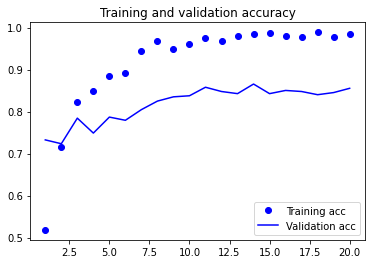

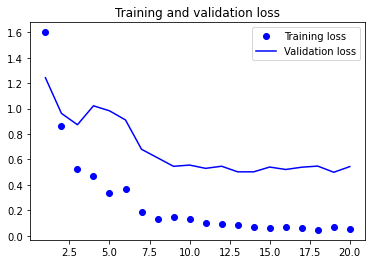

In [15]:
import matplotlib.pyplot as plt

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

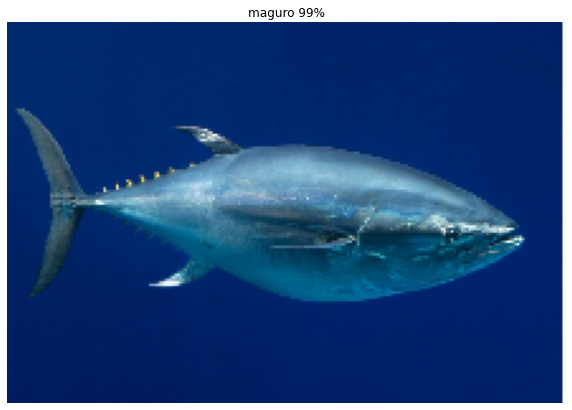

In [50]:
#画像多数の予測
%matplotlib inline
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
img1 = image.load_img('57.jpg', target_size=(image_height, image_width))
img = image.img_to_array(img1)
img = img/255.0
img = np.expand_dims(img, axis=0)
result = model.predict(img)
predicted = result.argmax(axis=1)
plt.figure(figsize=(10,10))
plt.axis("off")
percentage = int(result[0][predicted[0]] * 100)
plt.title(classes[predicted[0]] + " " + str(percentage) + "%")
plt.imshow(img1, cmap=plt.cm.binary)
plt.show()

In [24]:
import coremltools
import keras
from keras.models import load_model

#model = load_model()

coreml_model = coremltools.converters.keras.convert(
    'fish_modelv3_keras.h5', 
    input_names=['image'], 
    output_names=['output'],
    image_input_names='image',
    input_name_shape_dict={'image': [None, image_height, image_width, 3]},
    class_labels= ["aji", "ika", "iwashi", "katsuo", "maguro", "saba", "salmon", "sanma", "tai", "tako"]
    )

coreml_model.author = 'Ria Heikkila'
coreml_model.short_description = 'Fish Species Classifier converted from a Keras model'
coreml_model.input_description['image'] = 'Takes as input an image'
coreml_model.output_description['output'] = 'Prediction as one of 10 fish species'

coreml_model.save('fish_modelv3_keras.mlmodel')

0 : input_1, <keras.engine.input_layer.InputLayer object at 0x7fac9d8b52e8>
1 : conv2d_1, <keras.layers.convolutional.Conv2D object at 0x7fac9d8b5358>
2 : batch_normalization_1, <keras.layers.normalization.BatchNormalization object at 0x7fac9d8b5390>
3 : activation_1, <keras.layers.core.Activation object at 0x7fac9d8b5518>
4 : conv2d_2, <keras.layers.convolutional.Conv2D object at 0x7fac9d8b5780>
5 : batch_normalization_2, <keras.layers.normalization.BatchNormalization object at 0x7fac9d8b56a0>
6 : activation_2, <keras.layers.core.Activation object at 0x7fac9d8b5908>
7 : conv2d_3, <keras.layers.convolutional.Conv2D object at 0x7fac9d8b5a20>
8 : batch_normalization_3, <keras.layers.normalization.BatchNormalization object at 0x7fac9d8b5a58>
9 : activation_3, <keras.layers.core.Activation object at 0x7fac9d8b5be0>
10 : max_pooling2d_1, <keras.layers.pooling.MaxPooling2D object at 0x7fac9d8b5cf8>
11 : conv2d_4, <keras.layers.convolutional.Conv2D object at 0x7fac9d8b5d30>
12 : batch_normali